<a href="https://colab.research.google.com/github/Dyuloka/ML_Basics/blob/main/ML_PROJ1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q xgboost
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
df=pd.read_csv('AmesHousing.csv')

In [ ]:
df.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


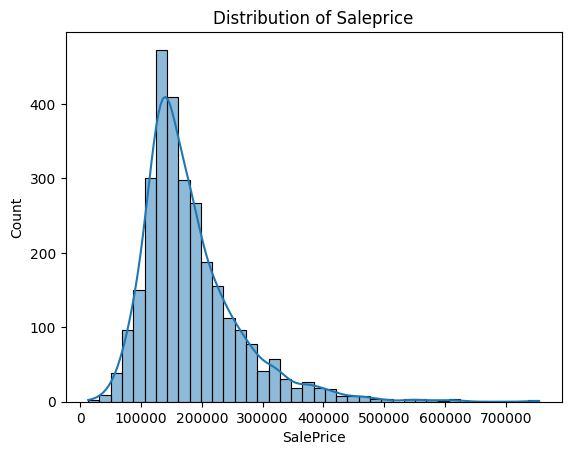

In [ ]:
sns.histplot(df['SalePrice'],kde=True,bins=40)
plt.title("Distribution of Saleprice")
plt.show()

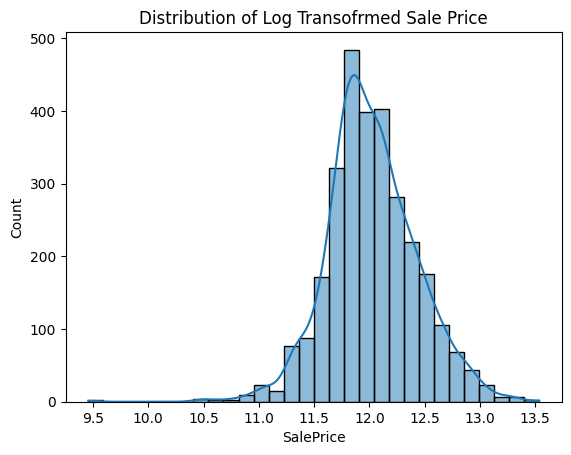

In [ ]:
sns.histplot(np.log1p(df['SalePrice']),kde=True,bins=30)
plt.title('Distribution of Log Transofrmed Sale Price')
plt.show()

In [ ]:
df['SalePrice'].skew(), np.log1p(df['SalePrice']).skew()

(np.float64(1.7435000757376466), np.float64(-0.014772659537224382))

In [ ]:
df.isnull().sum()

,0
Order,0
PID,0
MS SubClass,0
MS Zoning,0
Lot Frontage,490
...,...
Mo Sold,0
Yr Sold,0
Sale Type,0
Sale Condition,0


In [ ]:
missing=df.isnull().sum().sort_values(ascending=False)
missing[missing>0].head(15)

,0
Pool QC,2917
Misc Feature,2824
Alley,2732
Fence,2358
Mas Vnr Type,1775
Fireplace Qu,1422
Lot Frontage,490
Garage Qual,159
Garage Yr Blt,159
Garage Cond,159


In [ ]:
df['Garage Yr Blt'].sample(5)

,Garage Yr Blt
1226,1955.0
512,2005.0
2077,1954.0
762,NaN
2357,1974.0


In [ ]:
for col in ['Pool QC', 'Misc Feature', 'Alley', 'Fence', 'Fireplace Qu',
            'Garage Type', 'Garage Finish', 'Garage Qual', 'Garage Cond', 'Mas Vnr Type']:
            df[col]=df[col].fillna('Missing')

df['Lot Frontage']=df['Lot Frontage'].fillna(df['Lot Frontage'].median())
df['Mas Vnr Area']=df['Mas Vnr Area'].fillna(0)
df['Garage Yr Blt']=df['Garage Yr Blt'].fillna(0)

In [ ]:
# Impute numerical columns with their median
numerical_cols_to_impute_median = [
    'Bsmt Half Bath', 'Bsmt Full Bath', 'Bsmt Unf SF', 'BsmtFin SF 1',
    'BsmtFin SF 2', 'Total Bsmt SF', 'Garage Cars', 'Garage Area'
]
for col in numerical_cols_to_impute_median:
    # Ensure column is numeric before calculating median and filling NaNs
    # In case it was accidentally converted to object type earlier
    if df[col].dtype == 'object':
        df[col] = pd.to_numeric(df[col], errors='coerce') # Convert to numeric, non-convertible become NaN
    df[col] = df[col].fillna(df[col].median())

# Impute categorical columns with 'Missing'
categorical_cols_to_impute_missing = [
    'Bsmt Exposure', 'BsmtFin Type 2', 'Bsmt Qual', 'Bsmt Cond',
    'BsmtFin Type 1', 'Electrical'
]
for col in categorical_cols_to_impute_missing:
    df[col] = df[col].fillna('Missing')

In [ ]:
# Filters the results from the sum() method to only show columns where the sum is greater than 0

In [ ]:
x=df.drop(['SalePrice','Order','PID'],axis=1)
y=np.log1p(df['SalePrice'])


In [ ]:
x.shape,y.shape


((2930, 79), (2930,))

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(
    x,y,test_size=0.2,random_state=42
)

print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)


(2344, 79) (586, 79) (2344,) (586,)


In [ ]:
num_cols=x.select_dtypes(include=['int64','float64']).columns
cat_cols=x.select_dtypes(include='object').columns


In [ ]:
len(num_cols),len(cat_cols)


(36, 43)

In [ ]:
# Ensure all categorical columns are string type
x_train[cat_cols] = x_train[cat_cols].astype(str)
x_test[cat_cols] = x_test[cat_cols].astype(str)


In [ ]:

num_pipe=Pipeline([
    ('scaler',StandardScaler())
])

cat_pipe=Pipeline([
    ('encoder',OneHotEncoder(handle_unknown='ignore',sparse_output=False))
])

preprocessr=ColumnTransformer([
    ('num',num_pipe,num_cols),
    ('cat',cat_pipe,cat_cols)
])

model=Pipeline([
    ('preprocess',preprocessr),
    ('model',Ridge(alpha=1.0))
])


In [ ]:
from sklearn.preprocessing import FunctionTransformer


In [ ]:
model.fit(x_train,y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['MS SubClass', 'Lot Frontage', 'Lot Area', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area',
       'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area',
       'Bsmt Full Bath', 'Bsmt H...
       'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Exter Qual',
       'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating', 'Heating QC',
       'Central Air', 'Electrical', 'Kitchen Qual', 'Functional',
       'Fireplace Qu', 'Garage Type', 'Garage Finish', 'Garage Qual',
       'Garage Cond', 'Paved Drive', 'Pool QC', 'Fence', 'Misc Feature',
       'Sale Type', 'Sale Condition'],
      dtype='object'))])),
                ('model', Ridge())])

In [ ]:
y_pred = model.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")

RMSE: 0.11877172920403256


In [ ]:
print(f"The RMSE of the model on the test set is: {rmse}")

The RMSE of the model on the test set is: 0.11877172920403256


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
rf_model=Pipeline([
    ('preprocessor',preprocessr),
    ('regressor', RandomForestRegressor(
        n_estimators=200,
        random_state=42,
        n_jobs=-1,
    ))
])

rf_model.fit(x_train,y_train)
y_pref_rf=rf_model.predict(x_test)
rmse_rf=np.sqrt(mean_squared_error(y_test,y_pref_rf))
print(rmse_rf)

0.12172372005096886


In [ ]:
# Get feature names after preprocessing
num_features = preprocessr.named_transformers_['num'].named_steps['scaler'].get_feature_names_out(num_cols)
cat_features = preprocessr.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(cat_cols)
all_features = np.concatenate([num_features, cat_features])

# Get feature importances
importances = rf_model.named_steps['regressor'].feature_importances_

# Create a DataFrame for easier visualization
feat_imp_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display top 15 features
feat_imp_df.head(15)

,Feature,Importance
3,Overall Qual,0.587507
15,Gr Liv Area,0.084977
25,Garage Cars,0.045008
26,Garage Area,0.035616
12,1st Flr SF,0.030918
11,Total Bsmt SF,0.029745
8,BsmtFin SF 1,0.015423
2,Lot Area,0.012833
5,Year Built,0.012730
6,Year Remod/Add,0.009779


In [ ]:
# run in a Colab cell (prefix with ! for shell). Replace USER and REPO.
!git --version

git version 2.34.1
